# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [1]:
name = 'Faran Taimoor Butt'
if name == '':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [42]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests
        import unittest
        import networkx as nx
        from urllib.parse import urljoin
        from unittest.mock import patch, Mock
        from typing import Generator, List, Set, Deque, Tuple, Optional
        from collections import deque
        from functools import wraps
        from datetime import datetime
        import random
        import matplotlib.pyplot as plt
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
        ! pip install urllib
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [3]:
class WebCrawler:
  def get_response(self,url:str) -> str:
    try:
      response = requests.get(url)
      response.raise_for_status()
      return response.text
    except requests.RequestException:
      raise Exception(f'Failed to fetch {url} : {requests.RequestException}')

  def get_links(self,response:str,base_url:str) -> list:
    crawler = BeautifulSoup(response,'html.parser')
    links = []
    for link in crawler.find_all('a'):
      href = link['href']
      if href.startswith('http') or href.startswith('https'):
        links.append(href)
    return links

In [4]:
def get_all_links(url: str):
    """
    Get all the links in the webpage at the given URL

    :param url: A string that is the URL of the webpage where we need to find the links
    :return: A list with all the links of the given webpage
    """
    crawler = WebCrawler()
    try:
       page = crawler.get_response(url)
       links = crawler.get_links(page,url)
       return links
    except Exception:
      print(f"Failed to fetch {url}")
      return []

In [5]:
class TestWebCrawler(unittest.TestCase):
  def setUp(self):
    self.crawler = WebCrawler()
  @patch('requests.get')
  def testing_invalid_url(self,mock_get):
    mock_get.return_value.status_code = 200
    mock_get.return_value.text =  '<html><a href="https://example.com" >Link<\a><\html>'
    response = self.crawler.get_response('http://validurl.com')
    self.assertIn('<html>', response)
  @patch('requests.get')
  def testing_Invalid_URl(self,mock_get):
    mock_get.side_effect = requests.RequestException("Invalid URL")
    with self.assertRaises(Exception):
      self.crawler.get_response('http://invalidurl.com')
  def test_get_links(self):
    html_content = """
        <html>
            <a href="https://example.com">Example</a>
            <a href="/relative">Relative</a>
            <a href="mailto:test@example.com">Email</a>
        </html>
    """
    links = self.crawler.get_links(html_content,'http://baseurl.com')
    expected_links = [
          'https://example.com',
    ]
    self.assertEqual(links,expected_links)

  @patch('requests.get')
  def test_all_links_validity(self,mock_get):
    mock_get.return_value.status_code = 200
    mock_get.return_value.text = '<html><a href="https://example.com">Link</a></html>'
    links = get_all_links('http://validurl.com')
    self.assertEqual(links, ['https://example.com'])
  @patch('requests.get')
  def test_all_invalid_links(self,mock_get):
    mock_get.side_effect = requests.RequestException('Invalid URL')
    links = get_all_links('http://invalidurl.com')
    self.assertEqual(links, [])

In [6]:
if __name__=='__main__':
  unittest.main(argv=[''],exit=False)
  print("Fetching ALL URLS......")
  links = get_all_links('http://en.wikipedia.com')
  print("Links -> ", links[:10])

.....
----------------------------------------------------------------------
Ran 5 tests in 0.022s

OK


Failed to fetch http://invalidurl.com
Fetching ALL URLS......
Links ->  ['https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sidebar&wmf_campaign=en.wikipedia.org&uselang=en', 'https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sidebar&wmf_campaign=en.wikipedia.org&uselang=en', 'https://commons.wikimedia.org/wiki/Main_Page', 'https://foundation.wikimedia.org/wiki/Home', 'https://www.mediawiki.org/wiki/MediaWiki', 'https://meta.wikimedia.org/wiki/Main_Page', 'https://outreach.wikimedia.org/wiki/Main_Page', 'https://wikisource.org/wiki/Main_Page', 'https://species.wikimedia.org/wiki/Main_Page', 'https://en.wikibooks.org/wiki/Main_Page']


## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [7]:
def get_neighbor_pages(url: str) -> Generator[str,None,None]:
    """
    Go through the links in the webpage at the given URL
    and yield the html content of each of them

    :param url: A string that is the URL of the webpage
    """

    crawler = WebCrawler()
    try:
      page:str = crawler.get_response(url)
      links : List[str] = crawler.get_links(page,url)
      for link in links:
        try:
          neighbour_page:str = crawler.get_response(link)
          yield neighbour_page
        except Exception as exe:
          print(f"Failed to fetch neighbour page -> {link}:{exe}")
    except Exception as exe:
      print(f"failed to fetch the intial page -> {url}:{exe}")


In [8]:
class TestGetNeighborPages(unittest.TestCase):
  @patch('requests.get')
  def test_get_neighbour_pages(self,mock_get:unittest.mock.Mock):
    mock_get.side_effect = [
        unittest.mock.Mock(status_code=200,text='<html><a href="https://example.com/page1">Link 1</a></html>'),
        unittest.mock.Mock(status_code=200,text='<html>Page 1 Content</html>'),
    ]
    generator: Generator[str,None,None] = get_neighbor_pages('http://example.com')
    self.assertEqual(next(generator),'<html>Page 1 Content</html>')

  @patch('requests.get')
  def test_neighbour_pages_innvalid_intial_url(self,mock_get:unittest.mock.Mock):
    mock_get.side_effect = requests.RequestException('Invalid URL')
    generator: Generator[str,None,None] = get_neighbor_pages('http://invalidurl.com')
    with self.assertRaises(Exception):
      next(generator)

  @patch('requests.get')
  def test_neighbour_pages_invalid_neigh_url(self,mock_get:unittest.mock.Mock):
    mock_get.side_effect = [
        unittest.mock.Mock(status_code=200,text='<html><a href="https://invalid.com">Link</a></html>'),
        requests.RequestException('Invalid URL')
    ]
    generator: Generator[str,None,None] = get_neighbor_pages('http://example.com')
    with self.assertRaises(StopIteration):
      next(generator)

In [9]:
if __name__=="__main__":
  unittest.main(argv=[''],exit=False)
  print("Fetching ALL URLS......")
  links = get_all_links('http://en.wikipedia.com')
  for i,page in enumerate(get_neighbor_pages('http://en.wikipedia.com')):
    print(f"Page {i+1} -> {page[:10]}....")

........
----------------------------------------------------------------------
Ran 8 tests in 0.058s

OK


failed to fetch the intial page -> http://invalidurl.com:Failed to fetch http://invalidurl.com : <class 'requests.exceptions.RequestException'>
Failed to fetch neighbour page -> https://invalid.com:Failed to fetch https://invalid.com : <class 'requests.exceptions.RequestException'>
Failed to fetch http://invalidurl.com
Fetching ALL URLS......
Page 1 -> <!DOCTYPE ....
Page 2 -> <!DOCTYPE ....
Page 3 -> <!DOCTYPE ....
Page 4 -> <!DOCTYPE ....
Page 5 -> <!DOCTYPE ....
Page 6 -> <!DOCTYPE ....
Page 7 -> <!DOCTYPE ....
Page 8 -> <!DOCTYPE ....
Page 9 -> <!DOCTYPE ....
Page 10 -> <!DOCTYPE ....
Page 11 -> <!DOCTYPE ....
Page 12 -> <!DOCTYPE ....
Page 13 -> <!DOCTYPE ....
Page 14 -> <!DOCTYPE ....
Page 15 -> <!DOCTYPE ....
Page 16 -> <!DOCTYPE ....
Page 17 -> <!DOCTYPE ....
Page 18 -> <!DOCTYPE ....
Page 19 -> <!DOCTYPE ....
Page 20 -> <!DOCTYPE ....
Page 21 -> 


<!DOCTY....
Page 22 -> 


<!DOCTY....
Page 23 -> <!DOCTYPE ....
Page 24 -> <!DOCTYPE ....
Page 25 -> <!DOCTYPE ....
Page 26 -> <!D

## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

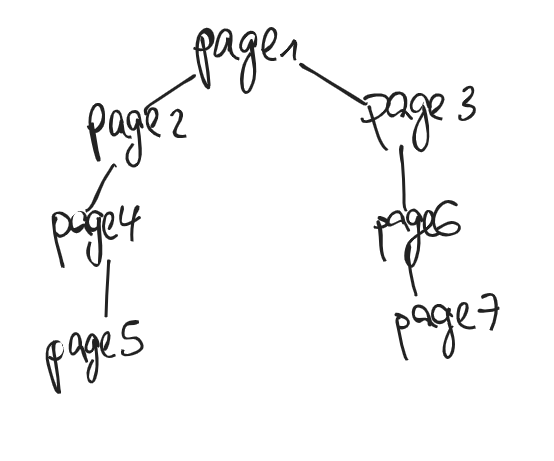

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [10]:
def get_pages_depth(url: str, depth: int) -> Generator[str, None, None]:
    """
    Generator function to yield HTML content of pages up to the specified depth.

    :param url: Starting URL.
    :param depth: Maximum depth to traverse.
    :yield: HTML content of each page.
    """
    visited: Set[str] = set()

    def _get_pages(current_url: str, current_depth: int) -> Generator[str, None, None]:
        if current_url in visited:
            return
        visited.add(current_url)
        if current_depth < 0:
            return
        try:
            page = WebCrawler().get_response(current_url)
            yield page
            if current_depth > 0:
                links = WebCrawler().get_links(page, current_url)
                for link in links:
                    yield from _get_pages(link, current_depth - 1)
        except Exception as e:
            print(f"Failed to fetch page {current_url}: {e}")

    yield from _get_pages(url, depth)

In [11]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [12]:
next(pages)

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-not-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Wikipedia, the free encyclopedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-di

In [13]:
class TestGetPagesDepth(unittest.TestCase):
    @patch('requests.get')
    def test_get_pages_depth_multiple_pages(self, mock_get) -> None:
        mock_responses = [
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page2">Link 2</a><a href="https://example.com/page3">Link 3</a></html>'
            ),
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page4">Link 4</a></html>'
            ),
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page6">Link 6</a></html>'
            ),
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page5">Link 5</a></html>'
            ),
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page7">Link 7</a></html>'
            ),
        ]
        mock_get.side_effect = mock_responses

        generator = get_pages_depth('https://example.com/page1', depth=2)
        pages = list(generator)

        expected_pages = [
            '<html><a href="https://example.com/page2">Link 2</a><a href="https://example.com/page3">Link 3</a></html>',
            '<html><a href="https://example.com/page4">Link 4</a></html>',
            '<html><a href="https://example.com/page6">Link 6</a></html>',
            '<html><a href="https://example.com/page5">Link 5</a></html>',
            '<html><a href="https://example.com/page7">Link 7</a></html>',
        ]

        self.assertEqual(len(pages), len(expected_pages))
        for expected_page in expected_pages:
            self.assertIn(expected_page, pages)

    @patch('requests.get')
    def test_get_pages_depth_cycle(self, mock_get) -> None:
        mock_responses = [
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page2">Link 2</a></html>'
            ),
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page1">Link 1</a></html>'
            ),
        ]
        mock_get.side_effect = mock_responses

        generator = get_pages_depth('https://example.com/page1', depth=2)
        pages = list(generator)

        expected_pages = [
            '<html><a href="https://example.com/page2">Link 2</a></html>',
            '<html><a href="https://example.com/page1">Link 1</a></html>',
        ]

        self.assertEqual(len(pages), len(expected_pages))
        for expected_page in expected_pages:
            self.assertIn(expected_page, pages)

    @patch('requests.get')
    def test_get_pages_depth_duplicate_links(self, mock_get) -> None:
        mock_responses = [
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page2">Link 2</a><a href="https://example.com/page3">Link 3</a></html>'
            ),
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page4">Link 4</a></html>'
            ),
            unittest.mock.Mock(
                status_code=200,
                text='<html><a href="https://example.com/page4">Link 4</a></html>'
            ),
            unittest.mock.Mock(
                status_code=200,
                text='<html>Page 4 Content</html>'
            ),
        ]
        mock_get.side_effect = mock_responses

        generator = get_pages_depth('https://example.com/page1', depth=2)
        pages = list(generator)

        expected_pages = [
            '<html><a href="https://example.com/page2">Link 2</a><a href="https://example.com/page3">Link 3</a></html>',
            '<html><a href="https://example.com/page4">Link 4</a></html>',
            '<html><a href="https://example.com/page4">Link 4</a></html>',
            '<html>Page 4 Content</html>',
        ]

        self.assertEqual(len(pages), len(expected_pages))
        for expected_page in expected_pages:
            self.assertIn(expected_page, pages)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

...........
----------------------------------------------------------------------
Ran 11 tests in 0.045s

OK


failed to fetch the intial page -> http://invalidurl.com:Failed to fetch http://invalidurl.com : <class 'requests.exceptions.RequestException'>
Failed to fetch neighbour page -> https://invalid.com:Failed to fetch https://invalid.com : <class 'requests.exceptions.RequestException'>
Failed to fetch http://invalidurl.com


## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [14]:
class ComputerScientist:
    def __init__(self, name, birthdate=None, major_achievements=None, alma_mater=None):
      self.name = name
      self.birthdate = birthdate
      self.major_achievements = major_achievements if major_achievements is not None else []
      self.alma_mater = alma_mater
    def __str__(self):
        return f"Name: {self.name}\nBirthdate: {self.birthdate}\nMajor Achievements: {', '.join(self.major_achievements)}\nAlma Mater: {self.alma_mater}"
    def add_achievement(self, achievement):
        self.major_achievements.append(achievement)
    def get_age(self):
        if self.birthdate:
            try:
                birth_date = datetime.strptime(self.birthdate, "%Y-%m-%d")
                today = datetime.today()
                return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
            except ValueError:
                return "Unknown"
        else:
            return "Unknown"

In [15]:
class TestComputerScientist(unittest.TestCase):
    def test_init(self):
        cs = ComputerScientist("Alan Turing", "1912-06-23", ["Turing Machine"], "King's College, Cambridge")
        self.assertEqual(cs.name, "Alan Turing")
        self.assertEqual(cs.birthdate, "1912-06-23")
        self.assertEqual(cs.major_achievements, ["Turing Machine"])
        self.assertEqual(cs.alma_mater, "King's College, Cambridge")

    def test_add_achievement(self):
        cs = ComputerScientist("Ada Lovelace")
        cs.add_achievement("First computer programmer")
        self.assertIn("First computer programmer", cs.major_achievements)

    def test_get_age(self):
        cs = ComputerScientist("Grace Hopper", "1906-12-09")
        age = cs.get_age()
        self.assertIsInstance(age, int)

    def test_get_age_missing_birthdate(self):
        cs = ComputerScientist("John Doe")
        age = cs.get_age()
        self.assertEqual(age, "Unknown")

    def test_get_age_invalid_birthdate(self):
        cs = ComputerScientist("John Doe", "Invalid Date")
        age = cs.get_age()
        self.assertEqual(age, "Unknown")

    def test_empty_major_achievements(self):
        cs = ComputerScientist("John Doe")
        self.assertEqual(cs.major_achievements, [])

    def test_missing_alma_mater(self):
        cs = ComputerScientist("John Doe")
        self.assertIsNone(cs.alma_mater)

    def test_add_multiple_achievements(self):
        cs = ComputerScientist("John Doe")
        cs.add_achievement("Achievement 1")
        cs.add_achievement("Achievement 2")
        self.assertEqual(cs.major_achievements, ["Achievement 1", "Achievement 2"])




In [16]:
def fetch_scientists():
    base_url = "https://en.wikipedia.org"
    list_url = "/wiki/List_of_computer_scientists"
    response = requests.get(base_url + list_url)
    soup = BeautifulSoup(response.content, "html.parser")
    scientist_links = []
    for li in soup.find_all("li"):
        a = li.find("a")
        if a and a.get("title") and "Wikipedia" not in a.get("title") and a.get("href", "").startswith("/wiki/"):
            scientist_links.append(a.get("href"))
    random.shuffle(scientist_links)
    selected_links = scientist_links[:100] if len(scientist_links) >= 100 else scientist_links

    scientists = []
    for link in selected_links:
        try:
            scientist_url = base_url + link
            scientist_response = requests.get(scientist_url)
            scientist_soup = BeautifulSoup(scientist_response.content, "html.parser")
            name = scientist_soup.find("h1", {"id": "firstHeading"}).text.strip()
            birthdate = None
            infobox = scientist_soup.find("table", {"class": "infobox"})
            if infobox:
                birth_data = infobox.find("th", string="Born")
                if birth_data:
                    birthdate = birth_data.find_next("td").text.strip().split("\n")[0]
            achievements = []
            awards_section = scientist_soup.find("span", {"id": "Awards_and_honors"})
            if awards_section:
                awards_list = awards_section.find_next("ul")
                if awards_list:
                    achievements = [li.text.strip() for li in awards_list.find_all("li")]
            alma_mater = None
            education_section = scientist_soup.find("span", {"id": "Education"})
            if education_section:
                education_list = education_section.find_next("ul")
                if education_list:
                    alma_mater = education_list.find("li").text.strip()
            cs = ComputerScientist(name, birthdate, achievements, alma_mater)
            scientists.append(cs)
        except Exception as e:
            print(f"Error fetching data for {link}: {e}")

    return scientists

In [17]:
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)
    scientist_list = fetch_scientists()
    for scientist in scientist_list:
      print(scientist)
      print("\n---\n")

...................
----------------------------------------------------------------------
Ran 19 tests in 0.063s

OK


failed to fetch the intial page -> http://invalidurl.com:Failed to fetch http://invalidurl.com : <class 'requests.exceptions.RequestException'>
Failed to fetch neighbour page -> https://invalid.com:Failed to fetch https://invalid.com : <class 'requests.exceptions.RequestException'>
Failed to fetch http://invalidurl.com
Name: Juris Hartmanis
Birthdate: (1928-07-05)July 5, 1928Riga, Latvia
Major Achievements: 
Alma Mater: None

---

Name: Andrew V. Goldberg
Birthdate: Andrew Vladislav Goldberg1960 (age 64–65)
Major Achievements: 
Alma Mater: None

---

Name: Joseph Halpern
Birthdate: May 29th, 1953Israel
Major Achievements: 
Alma Mater: None

---

Name: Christos Papadimitriou
Birthdate: Christos Charilaos Papadimitriou (Greek: Χρήστος Χαρίλαος "Χρίστος" Παπαδημητρίου) (1949-08-16) August 16, 1949 (age 75)Athens
Major Achievements: 
Alma Mater: None

---

Name: Derek McAuley
Birthdate: None
Major Achievements: 
Alma Mater: None

---

Name: Wilhelm Schickard
Birthdate: None
Major Achieveme

# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [32]:
from functools import wraps

def cache_requests(func):
    cache = {}

    @wraps(func)
    def wrapper(name):
        if name in cache:
            print(f"\nCached result for {name}...\n")
            return cache[name]
        result = func(name)
        cache[name] = result
        return result

    return wrapper

In [33]:
@cache_requests
def fetch_scientist(name):
    base_url = "https://en.wikipedia.org/wiki/"
    scientist_url = base_url + name.replace(" ", "_")
    response = requests.get(scientist_url)

    if response.status_code != 200:
        print(f"Failed to fetch data for {name}. HTTP Status Code: {response.status_code}")
        return None

    soup = BeautifulSoup(response.content, "html.parser")
    name = soup.find("h1", {"id": "firstHeading"})
    if not name:
        print(f"No results found for {name}.")
        return None
    name = name.text.strip()

    birthdate = None
    infobox = soup.find("table", {"class": "infobox"})
    if infobox:
        birth_data = infobox.find("th", string="Born")
        if birth_data:
            birthdate = birth_data.find_next("td").text.strip().split("\n")[0]

    achievements = []
    awards_section = soup.find("span", {"id": "Awards_and_honors"})
    if awards_section:
        awards_list = awards_section.find_next("ul")
        if awards_list:
            achievements = [li.text.strip() for li in awards_list.find_all("li")]

    alma_mater = None
    education_section = soup.find("span", {"id": "Education"})
    if education_section:
        education_list = education_section.find_next("ul")
        if education_list:
            alma_mater = education_list.find("li").text.strip()

    cs = ComputerScientist(name, birthdate, achievements, alma_mater)
    setattr(cs, "wikipedia_link", scientist_url)

    return cs

In [34]:
class TestComputerScientist(unittest.TestCase):
    def test_init(self):
        cs = ComputerScientist("Alan Turing", "1912-06-23", ["Turing Machine"], "King's College, Cambridge")
        self.assertEqual(cs.name, "Alan Turing")
        self.assertEqual(cs.birthdate, "1912-06-23")
        self.assertEqual(cs.major_achievements, ["Turing Machine"])
        self.assertEqual(cs.alma_mater, "King's College, Cambridge")

    def test_add_achievement(self):
        cs = ComputerScientist("Ada Lovelace")
        cs.add_achievement("First computer programmer")
        self.assertIn("First computer programmer", cs.major_achievements)

    def test_get_age(self):
        cs = ComputerScientist("Grace Hopper", "1906-12-09")
        age = cs.get_age()
        self.assertIsInstance(age, int)

    def test_get_age_missing_birthdate(self):
        cs = ComputerScientist("John Doe")
        age = cs.get_age()
        self.assertEqual(age, "Unknown")

    def test_get_age_invalid_birthdate(self):
        cs = ComputerScientist("John Doe", "Invalid Date")
        age = cs.get_age()
        self.assertEqual(age, "Unknown")

    def test_empty_major_achievements(self):
        cs = ComputerScientist("John Doe")
        self.assertEqual(cs.major_achievements, [])

    def test_missing_alma_mater(self):
        cs = ComputerScientist("John Doe")
        self.assertIsNone(cs.alma_mater)

    def test_add_multiple_achievements(self):
        cs = ComputerScientist("John Doe")
        cs.add_achievement("Achievement 1")
        cs.add_achievement("Achievement 2")
        self.assertEqual(cs.major_achievements, ["Achievement 1", "Achievement 2"])

In [35]:
class TestFetchScientist(unittest.TestCase):
    @patch('requests.get')
    def test_fetch_valid_scientist(self, mock_get):
        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.content = """
        <html>
            <h1 id="firstHeading">Alan Turing</h1>
            <table class="infobox">
                <tr><th>Born</th><td>23 June 1912</td></tr>
            </table>
            <h2><span id="Awards_and_honors">Awards and honors</span></h2>
            <ul>
                <li>Turing machine</li>
                <li>Turing test</li>
            </ul>
            <h2><span id="Education">Education</span></h2>
            <ul>
                <li>King's College, Cambridge</li>
            </ul>
        </html>
        """
        mock_get.return_value = mock_response

        scientist = fetch_scientist("Alan Turing")
        self.assertIsNotNone(scientist)
        self.assertEqual(scientist.name, "Alan Turing")
        self.assertEqual(scientist.birthdate, "23 June 1912")
        self.assertEqual(scientist.major_achievements, ["Turing machine", "Turing test"])
        self.assertEqual(scientist.alma_mater, "King's College, Cambridge")
        self.assertEqual(getattr(scientist, "wikipedia_link", None), "https://en.wikipedia.org/wiki/Alan_Turing")

In [36]:
if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)
    scientist = fetch_scientist("Alan Turing")
    if scientist:
        print(scientist)
        print(f"Wikipedia Link: {getattr(scientist, 'wikipedia_link', 'Not available')}")
    scientist = fetch_scientist("Alan Turing")
    if scientist:
        print(scientist)
        print(f"Wikipedia Link: {getattr(scientist, 'wikipedia_link', 'Not available')}")
    scientist = fetch_scientist("Non Existent Scientist")
    if scientist:
        print(scientist)
        print(f"Wikipedia Link: {getattr(scientist, 'wikipedia_link', 'Not available')}")

....................
----------------------------------------------------------------------
Ran 20 tests in 0.079s

OK


failed to fetch the intial page -> http://invalidurl.com:Failed to fetch http://invalidurl.com : <class 'requests.exceptions.RequestException'>
Failed to fetch neighbour page -> https://invalid.com:Failed to fetch https://invalid.com : <class 'requests.exceptions.RequestException'>
Failed to fetch http://invalidurl.com

Cached result for Alan Turing...

Name: Alan Turing
Birthdate: 23 June 1912
Major Achievements: Turing machine, Turing test
Alma Mater: King's College, Cambridge
Wikipedia Link: https://en.wikipedia.org/wiki/Alan_Turing

Cached result for Alan Turing...

Name: Alan Turing
Birthdate: 23 June 1912
Major Achievements: Turing machine, Turing test
Alma Mater: King's College, Cambridge
Wikipedia Link: https://en.wikipedia.org/wiki/Alan_Turing
Failed to fetch data for Non Existent Scientist. HTTP Status Code: 404


# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.

In [56]:
class ScientistGraph:
    def __init__(self):
        self.adjacency_list = {}
        self.scientist_objects = {}

    def add_scientist(self, name):
        if name in self.adjacency_list:
            print(f"scientit '{name}' already exist the graph.")
            return
        base_url = "https://en.wikipedia.org/wiki/"
        url = base_url + name.replace(" ", "_")
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Failed to fetch data for {name}. HTTP Status Code: {response.status_code}")
            return
        soup = BeautifulSoup(response.content, "html.parser")
        scientist_name = soup.find("h1", {"id": "firstHeading"}).text.strip()
        cs = ComputerScientist(scientist_name, wikipedia_link=url)
        self.scientist_objects[scientist_name] = cs
        self.adjacency_list[scientist_name] = []
        for a_tag in soup.find_all("a", href=True):
            href = a_tag["href"]
            if href.startswith("/wiki/") and not any(ext in href for ext in [":", "#"]):
                linked_name = a_tag.text.strip()
                if linked_name in self.adjacency_list:
                    self.adjacency_list[scientist_name].append(linked_name)
                    self.adjacency_list[linked_name].append(scientist_name)
        print(f" added scientist '{scientist_name}' in graph")

    def remove_scientist(self, name):
        if name not in self.adjacency_list:
            print(f"scientist '{name}' does not exist in the graph")
            return
        for scientist in self.adjacency_list[name]:
            self.adjacency_list[scientist].remove(name)
        del self.adjacency_list[name]
        del self.scientist_objects[name]
        print(f"removed scientist '{name}' from the graph")

    def plot(self):
        G = nx.DiGraph()
        for scientist, connections in self.adjacency_list.items():
            G.add_node(scientist)
            for conn in connections:
                G.add_edge(scientist, conn)
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=5000, font_size=10, arrowsize=20)
        plt.show()

    def rank_scientists(self, method='degree'):
        if method == 'degree':
            degrees = {scientist: len(connections) for scientist, connections in self.adjacency_list.items()}
            sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)
            for rank, (scientist, degree) in enumerate(sorted_degrees, start=1):
                print(f"{rank}. {scientist} - Degree: {degree}")
        elif method == 'pagerank':
            self._pagerank()
        else:
            raise ValueError("unsupported ranking method")

    def _pagerank(self, damping_factor=0.85, iterations=100):
        nodes = list(self.adjacency_list.keys())
        N = len(nodes)
        if N == 0:
            print("no scientists in the graph")
            return
        rank = {node: 1.0 / N for node in nodes}
        out_degree = {node: len(links) for node, links in self.adjacency_list.items()}
        dangling_nodes = [node for node in nodes if out_degree[node] == 0]
        dangling_mass = sum(rank[node] for node in dangling_nodes) / N
        for _ in range(iterations):
            new_rank = {node: (1 - damping_factor) / N + damping_factor * dangling_mass for node in nodes}
            for node in nodes:
                for neighbor in self.adjacency_list.get(node, []):
                    new_rank[neighbor] += damping_factor * rank[node] / out_degree[node]
            rank = new_rank
        sorted_ranks = sorted(rank.items(), key=lambda item: item[1], reverse=True)
        print("Ranking of Scientists by PageRank:")
        for rank_pos, (scientist, pr_score) in enumerate(sorted_ranks, start=1):
            print(f"{rank_pos}. {scientist} - PageRank: {pr_score:.5f}")

 added scientist 'Albert Einstein' in graph
 added scientist 'Marie Curie' in graph
 added scientist 'Isaac Newton' in graph
 added scientist 'Stephen Hawking' in graph


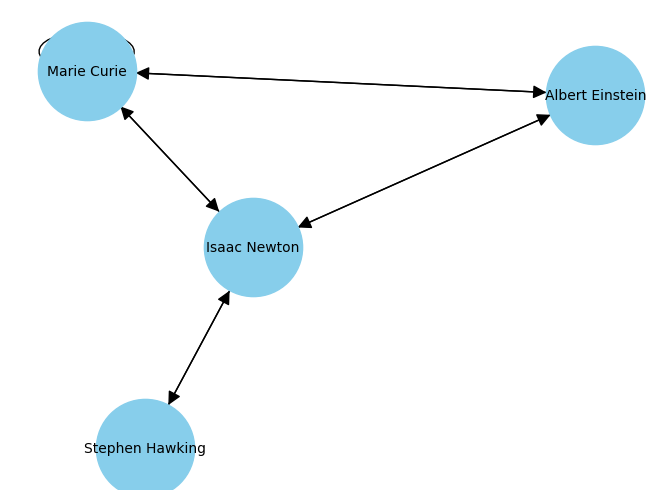

Ranking of Scientists by PageRank:
1. Marie Curie - PageRank: 0.34463
2. Isaac Newton - PageRank: 0.26498
3. Albert Einstein - PageRank: 0.24028
4. Stephen Hawking - PageRank: 0.15012
removed scientist 'Stephen Hawking' from the graph


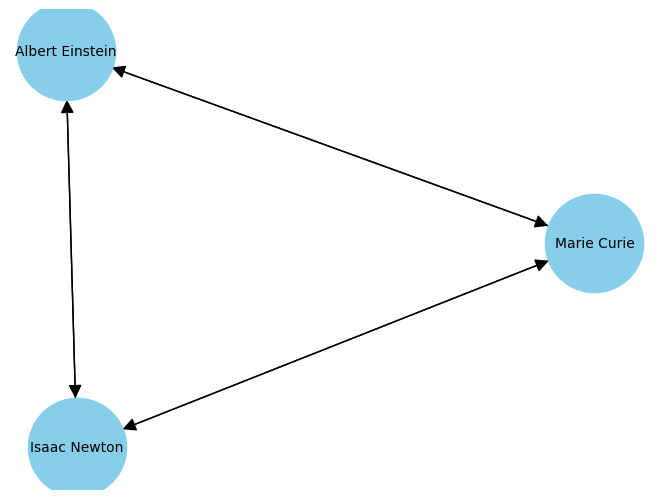

Ranking of Scientists by PageRank:
1. Marie Curie - PageRank: 0.47810
2. Albert Einstein - PageRank: 0.33333
3. Isaac Newton - PageRank: 0.18856


In [57]:
if __name__ == "__main__":
    graph = ScientistGraph()
    graph.add_scientist("Albert Einstein")
    graph.add_scientist("Marie Curie")
    graph.add_scientist("Isaac Newton")
    graph.add_scientist("Stephen Hawking")
    graph.plot()
    graph.rank_scientists(method='pagerank')
    graph.remove_scientist("Stephen Hawking")
    graph.plot()
    graph.rank_scientists(method='pagerank')